In [42]:
from data import load_covariates, load_target

In [54]:
# Load Data
target_series = load_target('../data/03_model_input/on_forecourt_sessions.csv', group_cols='location_id',
                            time_col='date', value_cols='energy_delivered_kwh', static_cols=['num_evse'], freq='D')[0]
covariates = load_covariates('../data/03_model_input/weather.csv', time_col='datetime',
                                value_cols=['tempmax', 'tempmin', 'snow', 'precip'], freq='D')


In [69]:
from darts.models import RNNModel, AutoARIMA, NaiveSeasonal
from darts.utils.likelihood_models import GaussianLikelihood
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from darts.dataprocessing.transformers.scaler import Scaler


my_stopper = EarlyStopping(
        monitor="val_loss",
        patience=5,
        min_delta=0.05,
        mode='min',
    )
    
optimizer_kwargs = {'lr': 0.1}
model = RNNModel(
        model="LSTM",
        hidden_dim=32, 
        n_rnn_layers=1,
        dropout=0,
        batch_size=64,
        optimizer_kwargs=optimizer_kwargs, 
        nr_epochs_val_period=1,
        log_tensorboard=True,
        # training_length=config['training_length'],
        input_chunk_length=64,
        random_state=0,
        likelihood=GaussianLikelihood(),
        pl_trainer_kwargs={"callbacks": [my_stopper]}
    )

In [70]:
# split training data
split = 0.7
target_train, target_val = target_series.split_after(split)

# scale training data
scaler = Scaler()

target_train = scaler.fit_transform(target_train)
target_val = scaler.transform(target_val)
target = scaler.transform(target_series)

# train model on training data
model.fit(
    series=target_train,
    # future_covariates=covariates,
    val_series=target_val,
    verbose=False,
)

# evaluate on all data
backtest = model.historical_forecasts(
    series=target,
    # val_series=target_val,
    num_samples=1,
    start=split,
    forecast_horizon=1,
    stride=1,
    retrain=False,
    # future_covariates=covariates,
    verbose=False,
)

# Reverse Scaling
predictions = scaler.inverse_transform(backtest)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\tijmen.vanetten\AppData\Local\miniconda3\envs\kedro\lib\site-packages\pytorch_lightning\loops\fit_loop.py:280: PossibleUserWarning: The number of training batches (11) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using

In [62]:
from eval import plot

TypeError: 'AxesSubplot' object is not subscriptable

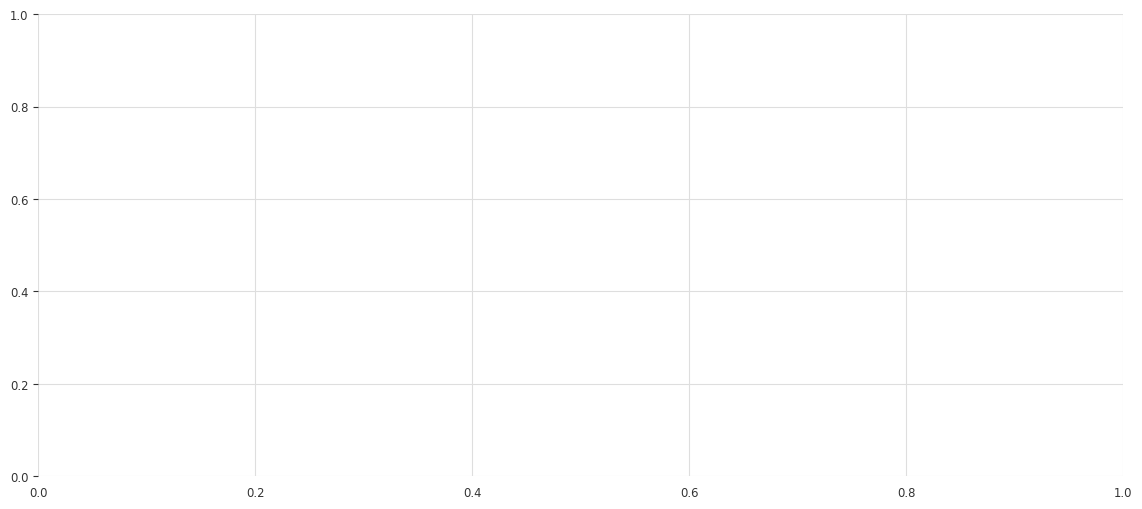

In [73]:
fig, axs = plot([predictions], [target_val])
fig.tight_layout()
fig.savefig("plots.png")

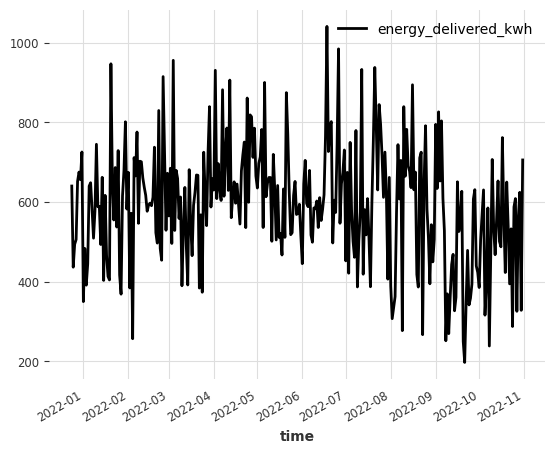

In [75]:
predictions.plot()

In [77]:
target_series[predictions.time_index]

<TimeSeries (DataArray) (date: 312, component: 1, sample: 1)>
array([[[ 679.46  ]],

       [[ 564.92  ]],

       [[ 849.768 ]],

       [[ 637.501 ]],

       [[ 527.386 ]],

       [[ 773.136 ]],

       [[ 655.925 ]],

       [[ 562.9625]],

       [[ 470.    ]],

       [[ 564.874 ]],

...

       [[ 529.912 ]],

       [[ 516.939 ]],

       [[ 903.89  ]],

       [[ 642.744 ]],

       [[ 612.837 ]],

       [[ 734.436 ]],

       [[ 651.805 ]],

       [[ 630.652 ]],

       [[ 686.72  ]],

       [[ 691.11  ]]])
Coordinates:
  * date       (date) datetime64[ns] 2021-12-24 2021-12-25 ... 2022-10-31
  * component  (component) object 'energy_delivered_kwh'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  static_covariates     location_id  num_evse\ncomponen...
    hierarchy:          None